# Magic Formula Investing: Implementation and Simulation Using Python
## By Zongning (ZiZi) Zhang, Connor Roberts, Xincheng You, and Samuel Lam

### Table of Contents
* Part A: Data Wrangling
    * Filling in data by cross-referencing the annual data with quarterly data
    * Dropping rows of data with missing crucial values 

## Part A: Cleaning the Data

In [1]:
# importing packages that are used throughout the code
import math
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams

In [2]:
# importing our raw data and viewing a tiny subset of it
# data was downloaded for the Wharton Research Data Services site, using the Compustat Database
# https://wrds-web.wharton.upenn.edu/wrds/support/Data/_003Sample%20Programs/Compustat/compna_translate_vars.cfm?

# df containly quarterly company fundamentals, such as debt, cash, PPE, etc
# Compustat does not contain quarterly EBIT values, which is crucial to our calculations
df=pd.read_csv("QuarterlyRawDataNoEBIT.csv")

# the Compustat database only offers EBIT on an annual basis, so ebit_df 
# contains annual data for each company's EBIT 
ebit_df=pd.read_csv("AnnualRawInputData.csv")

In [3]:
print "Length of Quarterly Data: ", len(df)
print "Length of Annual Data: ", len(ebit_df)
df.head()

Length of Quarterly Data:  512530
Length of Annual Data:  140522


,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,cstkq,dlcq,dlttq,ppentq,pstkq,wcapq,costat,mkvaltq,prccq,sic
0,1004,02/28/1990,1989,3,INDL,C,D,STD,AIR,AAR CORP,...,16.070,32.551,72.606,53.428,0,188.100,A,NaN,31.125,5080
1,1004,05/31/1990,1989,4,INDL,C,D,STD,AIR,AAR CORP,...,16.082,33.821,72.329,63.441,0,184.932,A,NaN,21.250,5080
2,1004,08/31/1990,1990,1,INDL,C,D,STD,AIR,AAR CORP,...,16.086,27.427,71.806,63.545,0,189.351,A,NaN,15.875,5080
3,1004,11/30/1990,1990,2,INDL,C,D,STD,AIR,AAR CORP,...,16.086,33.563,71.769,63.075,0,186.955,A,NaN,11.875,5080
4,1004,02/28/1991,1990,3,INDL,C,D,STD,AIR,AAR CORP,...,16.097,11.436,69.020,63.626,0,184.665,A,NaN,12.875,5080


In [4]:
# trimming data for years past 2014
df=df[df['fyearq']<2015]
ebit_df=ebit_df[ebit_df['fyear']<2015]

# eliminating duplicate data that is double-listed under FS and INDL 
ebit_df=ebit_df[ebit_df['indfmt']!="FS"]

# the length of both dataframes should be shortening
print len(df), len(ebit_df)

487706 124596


In [5]:
# extracting the companies that have missing EBIT values
missing_ebit_tics=ebit_df[ebit_df['ebit'].isnull()].tic.unique()

# removing those companies from our datasets 
df = df[~df.tic.isin(missing_ebit_tics)]
ebit_df = ebit_df[~ebit_df.tic.isin(missing_ebit_tics)]

# the length of both dataframes should be shortening
print len(df), len(ebit_df)

350463 87305


In [8]:
# function to get the appropriate annual EBIT value for each row in the quarterly dataframe
def get_row_ebit(row):
    ebit_row = ebit_df[ebit_df['fyear']==row['fyearq']]
    ebit_row = ebit_row[ebit_row['tic']== row['tic']]
    if ebit_row['ebit'].empty:
        return float('NaN')
    else: 
        return float(ebit_row['ebit'])

In [9]:
%%time 
# takes a while to run so don't run this every time
# the edited CSVs have been saved and can be loaded in separately 
df['ebit']=df.apply(get_row_ebit,axis=1)

CPU times: user 16min 18s, sys: 3.21 s, total: 16min 21s
Wall time: 16min 21s


In [10]:
# function to get the appropriate annual cash values for 
# rows with missing cash values in the quarterly dataframe
# 
# quarterly cash values are generally missing before 2007
def get_row_cash(row):
    if math.isnan(row['chq']):
        cash_row = ebit_df[ebit_df['datadate']==row['datadate']]
        cash_row = cash_row[cash_row['tic']==row['tic']]
        if cash_row['ch'].empty:
            return float('NaN')
        else: 
            return float(cash_row['ch'])
    else: 
        return row['chq']    

In [11]:
%%time
# also takes around 10-15 minutes
df['chq']=df.apply(get_row_cash,axis=1)

CPU times: user 19min 56s, sys: 1.75 s, total: 19min 58s
Wall time: 19min 58s


In [30]:
# function to get the appropriate annual mkvalt values for 
# rows with missing cash values in the quarterly dataframe
# 
# quarterly cash values are generally missing before 2007
def get_row_mkvalt(row):
    if math.isnan(row['mkvaltq']):
        cash_row = ebit_df[ebit_df['datadate']==row['datadate']]
        cash_row = cash_row[cash_row['tic']==row['tic']]
        if cash_row['mkvalt'].empty:
            return float('NaN')
        else: 
            return float(cash_row['mkvalt'])
    else: 
        return row['mkvaltq'] 

In [31]:
%%time
# also takes around 10-15 minutes
df['mkvaltq']=df.apply(get_row_mkvalt,axis=1)

CPU times: user 4min 33s, sys: 969 ms, total: 4min 34s
Wall time: 4min 35s


In [33]:
# dropping the rows that still have missing cash values in the quarterly dataset
df=df[~np.isnan(df['chq'])]

# dropping the rows that still have missing EBIT values in the quarterly dataset
df=df[~np.isnan(df['ebit'])]


# dropping the rows with missing market values (mkvaltq) in the quarterly dataset
df=df[~np.isnan(df['mkvaltq'])]
print len(df)

# export to CSV so we don't have to rerun the cleaning and get_row_ebit/get_row_cash functions everytime
df.to_csv("CleanedQuarterlyEBITCash.csv")
ebit_df.to_csv("CleanedAnnualEBIT.csv")

99836


# Start here to avoid running data-cleaning code above
### (which takes ~30 minutes)

In [34]:
# re-read in the cleaned dataframes
df=pd.read_csv("CleanedQuarterlyEBITCash.csv")
ebit_df=pd.read_csv("CleanedAnnualEBIT.csv")
print len(df), len(ebit_df)

# drop the index column that gets added mysteriously during exporting

if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
if 'Unnamed: 0' in ebit_df.columns:
    ebit_df.drop('Unnamed: 0', axis=1, inplace=True)

99836 87305


In [35]:
# get a list of all the unique tickers in our datasets
tics = pd.DataFrame(data=df['tic'].unique(), columns=['ticker'])
tics.to_csv('AllUniqueTickers.csv')

## 1. Establish minimum market capitalization value of 50M

#### Filter out companies that do not meet this minimum

In [67]:
# we write a function here that will be used later once the year of simulation is determined
# year >= 1998, since mkvaltq are not reported before then 

# returns a list of companies that meet the minimum market cap requirement in a given year
min_market_cap = 50
def set_min_market_cap(df, year):
    df_for_year = df[df['fyearq']==year]
    # print df_for_year
    df_for_year = df_for_year[df_for_year['mkvaltq']>min_market_cap]
    return list(df_for_year['tic'])
# set_min_market_cap(df,1998)
# df[df['fyearq']==2006]

## 2. Excluding utility and financial companies

In [68]:
# remove SIC Division H Companies: Finance, Insurance, and Real Estate
# https://www.osha.gov/pls/imis/sic_manual.html
df_below_6000=df[df['sic']<6000]
df_above_7000=df[df['sic']>=7000]

df=pd.concat([df_below_6000,df_above_7000])

# still shortening
print len(df), len(ebit_df)

99836 87305


In [38]:
# remove SIC Division E Companies: Transportation, Communications, Electric, Gas, and Sanitary Services
# https://www.osha.gov/pls/imis/sic_manual.html
df_below_4000=df[df['sic']<4000]
df_above_5000=df[df['sic']>=5000]

df=pd.concat([df_below_4000,df_above_5000])

# still shortening
print len(df), len(ebit_df)

99836 87305


## 3. Calculating Earnings Yield: EBIT/EV

In [39]:
# basic function to calculate ratio 1 across a row
# ratio 1 = EBIT / EV
# EBIT = earnings before interest and taxes, after subtracting depreciation and amortization
# EV = enterprise value = market cap + debt - cash
# EV = MKVALTQ + DTQ - CHQ
# MKVALTQ = market cap = value of preferred stock + value of common stock
# MKVALTQ = PSTKQ + CSTKQ 
# DTQ = debt = long-term debt + net current debt
# DTQ = DLTTQ + DLCQ
# CHQ = cash
# ratio 1 = EBIT / (MKVALTQ + DLCQ + DLTTQ - CHQ)
def ratio_one(row):
    if math.isnan(row['mkvaltq']) or math.isnan(row['dlcq']) or math.isnan(row['dlttq']) or math.isnan(row['chq']) or (row['mkvaltq']+row['dlcq']+row['dlttq']-row['chq'])==0: 
        ratio = float('NaN')
    else: 
        ratio=row['ebit']/(row['mkvaltq']+row['dlcq']+row['dlttq']-row['chq'])
    return ratio

In [40]:
%%time
# add the ratio1 column to the dataframe
df['ratio1']=df.apply(ratio_one,axis=1)

CPU times: user 4.77 s, sys: 36.1 ms, total: 4.8 s
Wall time: 4.8 s


## 4. Calculating Return on Capital: EBIT/(NFA + NWC)

In [41]:
# basic function to calculate ratio 2 across a row
# ratio 2 = EBIT / (NFA + NWC)
# EBIT = earnings before interest and taxes, after subtracting depreciation and amortization
# NFA = net fixed assets = net book value of Property Plant and Equipment (PPENTQ)
# NMW = net working capital = working capital - cash = WCAPQ - CHQ
def ratio_two(row):
    if math.isnan(row['ppentq']) or math.isnan(row['wcapq']) or math.isnan(row['chq']) or row['ppentq']+row['wcapq']-row['chq']==0:
        ratio = float('NaN')
    else: 
        ratio=row['ebit']/(row['ppentq']+row['wcapq']-row['chq'])
    return ratio

In [42]:
%%time
# add the ratio2 column to the dataframe
df['ratio2']=df.apply(ratio_two,axis=1)

CPU times: user 3.68 s, sys: 13 ms, total: 3.7 s
Wall time: 3.69 s


In [43]:
# our dataframe now has two additional columns: ratio1 and ratio2
df.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,ppentq,pstkq,wcapq,costat,mkvaltq,prccq,sic,ebit,ratio1,ratio2
0,1050,12/31/1998,1998,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,2.062,0,0.372,A,24.7530,3.000,3564,1.137,0.041276,0.549541
1,1050,12/31/1999,1999,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,14.244,0,14.342,A,20.6275,2.500,3564,0.442,0.008740,0.016101
2,1050,12/31/2000,2000,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,13.587,0,11.632,A,10.8433,1.375,3564,2.009,0.050154,0.081816
3,1050,12/31/2001,2001,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,13.136,0,8.063,A,31.7262,3.300,3564,4.305,0.081093,0.203585
4,1050,12/31/2002,2002,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,12.122,0,6.277,A,17.7415,1.850,3564,2.201,0.061361,0.120901


## 5. Ranking the companies based on calculated ratios
### and extracting the top 20-30 companies

In [44]:
df.head()

,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,tic,conm,...,ppentq,pstkq,wcapq,costat,mkvaltq,prccq,sic,ebit,ratio1,ratio2
0,1050,12/31/1998,1998,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,2.062,0,0.372,A,24.7530,3.000,3564,1.137,0.041276,0.549541
1,1050,12/31/1999,1999,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,14.244,0,14.342,A,20.6275,2.500,3564,0.442,0.008740,0.016101
2,1050,12/31/2000,2000,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,13.587,0,11.632,A,10.8433,1.375,3564,2.009,0.050154,0.081816
3,1050,12/31/2001,2001,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,13.136,0,8.063,A,31.7262,3.300,3564,4.305,0.081093,0.203585
4,1050,12/31/2002,2002,4,INDL,C,D,STD,CECE,CECO ENVIRONMENTAL CORP,...,12.122,0,6.277,A,17.7415,1.850,3564,2.201,0.061361,0.120901


In [69]:
# get a sorted datafframe of the eligible companies for a given year
# year >=1998
# we can also specify the weights of the two ratios used to create the overall ranking
def get_top(df, year, ratio1weight):
    # eliminate companies that do not meet the min market cap
    # print set_min_market_cap(df, year)
    short_df = df[df['tic'].isin(set_min_market_cap(df, year))]
    short_df = short_df[short_df['fyearq']==year]
    
    # rank the rows based on ratio1 and ratio2, with a larger ratio ==> better ranking
    short_df['rank1'] = short_df['ratio1'].rank(ascending=False,na_option='bottom')
    short_df['rank2'] = short_df['ratio2'].rank(ascending=False,na_option='bottom')
    
    # sum the two ranks based on the specified ratio1weight parameter
    short_df['ranksum'] = ratio1weight * short_df['rank1']+ (1-ratio1weight) * short_df['rank2']
    
    # get the final ranking from the combined sum
    short_df['finalrank'] = short_df['ranksum'].rank(ascending=True,na_option='bottom')
    sorted_short = short_df.sort(columns='finalrank',ascending=True)
    
    # return a tuple of the sorted dataframe and the sorted list of unique tickers 
    return sorted_short, list(sorted_short.tic.unique())
# get_top(df,1998,0.5)[1]

## 6. Invest in 30 highest-ranked companies
We are simulating a 1,000,000 dollar portfolio. 

In [70]:
# monthly stock price data is downloaded from CRSP database
prices_df=pd.read_csv("CRSPMonthlyPrices.csv")
prices_df.head()

,Unnamed: 0,PERMNO,date,SICCD,TICKER,COMNAM,PRC,CFACPR,PRCADJUST,year
0,0,10001,1/31/90,4920,GFGC,GREAT FALLS GAS CO,-9.9375,3,29.8125,1990
1,1,10001,2/28/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
2,2,10001,3/30/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
3,3,10001,4/30/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
4,4,10001,5/31/90,4920,GFGC,GREAT FALLS GAS CO,9.7500,3,29.2500,1990


In [71]:
if 'Unnamed: 0' in prices_df.columns:
    prices_df.drop('Unnamed: 0', axis=1, inplace=True)
if 'Unnamed: 0.1' in prices_df.columns:
    prices_df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [72]:
prices_df.head()

,PERMNO,date,SICCD,TICKER,COMNAM,PRC,CFACPR,PRCADJUST,year
0,10001,1/31/90,4920,GFGC,GREAT FALLS GAS CO,-9.9375,3,29.8125,1990
1,10001,2/28/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
2,10001,3/30/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
3,10001,4/30/90,4920,GFGC,GREAT FALLS GAS CO,-9.8750,3,29.6250,1990
4,10001,5/31/90,4920,GFGC,GREAT FALLS GAS CO,9.7500,3,29.2500,1990


In [49]:
# calculate the adjusted price for each row
# adjusted price = absolute price * monthly cumulative adjustment factor 
# PRCADJUST = PRC * CFACPR
def get_adjusted_price(row):
    # some prices are negative to indicate that 
    # they are an average of bid and ask price 
    # because closing price was not available
    if row['PRC']<0:
        return -row['PRC']*row['CFACPR']
    else: 
        return row['PRC']*row['CFACPR']

In [51]:
# add the PRCADJUST column to the dataframe
prices_df['PRCADJUST']=prices_df.apply(get_adjusted_price,axis=1)

In [52]:
import dateutil.parser as parser

# parse out the year from the date value
def get_year(row):
    return parser.parse(row['date']).year

# add the year column to the dataframe
prices_df['year']=prices_df.apply(get_year,axis=1)

In [73]:
# drop rows with missing PRCADJUST values
prices_df=prices_df[~np.isnan(prices_df['PRCADJUST'])]

# save the dataframe to a CSV
prices_df.to_csv("CRSPMonthlyPrices.csv")

In [151]:
def simulate_year(year,ratio1weight,timespan):
    stock_list=get_top(df,year,ratio1weight)[1]
    # limit the total number of stock positions that will be acquired
    TOTALNUMSTOCKS=30
    
    # set a default portfolio size of one million dollars (we wish!!!! )
    portfolio_size=1000000
    
    # distribute the portfolio size equally amongst the 30 stocks
    amount_per_stock=portfolio_size/TOTALNUMSTOCKS

    # keep track of the number of stocks we have purchased 
    num_stocks=0
    
    # accumulating total change in our portfolio amount
    total_change=0
    
    # for each stock, we want 
    # quantity of stock purchased at end of Jan * (change in value over year)     
    for stock in stock_list:
        stock_prices= prices_df[prices_df['TICKER']==stock]
        stock_prices=stock_prices[stock_prices['year']>=year]
        stock_prices=stock_prices[stock_prices['year']<year+timespan]
        # check that we have data from this specific stock and year
        if len(stock_prices)!=0 and stock_prices.head(1).PRCADJUST.values[0] != 0:             
            # price at beginning of year 
            start_price=stock_prices.head(1).PRCADJUST.values[0] 
            
            # price at ending of year 
            end_price=stock_prices.tail(1).PRCADJUST.values[0]
            
            # total number of shares purchased with allocated amount at start_price
            shares_purchased = amount_per_stock/start_price 
            
            # change in value of each share over year
            change_over_year= end_price-start_price
            
            # accumulate total change
            total_change = total_change+shares_purchased*change_over_year

            num_stocks=num_stocks+1
            if num_stocks>TOTALNUMSTOCKS:
                break
    return portfolio_size+total_change

In [152]:
simulate_year(2001, 0.5,1)

1317468.9894389827

In [139]:
%%time
# perform a basic cross-validation across the years and different ratio weights
d={} # dict keyed by year with returns for that year with different ratioweight values 
for year in range(1998,2015):
    d[year]=[]
    for ratio in [0.125,0.25,0.375,0.5,0.625,0.75,0.875]:
        # print year,ratio, simulate_year(year, ratio,1)
        d[year].append(simulate_year(year, ratio,1))    

CPU times: user 7min 47s, sys: 7.03 s, total: 7min 54s
Wall time: 7min 54s


ratios=[0.125,0.25,0.375,0.5,0.625,0.75,0.875]
plt.scatter(ratios,d[2001])
print d[2001]

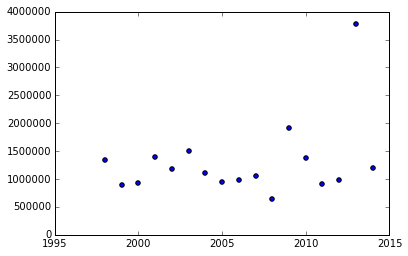

In [148]:
# dict keyed by ratio weight with returns for each year using that specific ratioweight
d_by_ratio={}
for ratio in ratios: 
    d_by_ratio[ratio]=[]
    i=0
    for year in range(1998,2015):
        d_by_ratio[ratio].append(d[year][i])
    i=i+1
plt.scatter(range(1998,2015),d_by_ratio[0.375])

In [155]:
# very similar to simulate_year, except now we can specific the starting portfolio size
def simulate_year_recursive(portfolio_size, year,ratio1weight):
    stock_list=get_top(df,year,ratio1weight)[1]
    TOTALNUMSTOCKS=30
    
    amount_per_stock=portfolio_size/TOTALNUMSTOCKS 
    num_stocks=0
    total_change=0
    for stock in stock_list:
        stock_prices= prices_df[prices_df['TICKER']==stock]
        stock_prices=stock_prices[stock_prices['year']==year]
        # stock_prices=stock_prices[stock_prices['year']<year+timespan]
        # check that we have data from this specific stock and year
        if len(stock_prices)!=0 and stock_prices.head(1).PRCADJUST.values[0] != 0:             
            # price at beginning of year 
            start_price=stock_prices.head(1).PRCADJUST.values[0] 
            
            # price at ending of year 
            end_price=stock_prices.tail(1).PRCADJUST.values[0]
            
            # total number of shares purchased with allocated amount at start_price
            shares_purchased = amount_per_stock/start_price 
            
            # change in value of each share over year
            change_over_year= end_price-start_price
            
            # accumulate total change
            total_change = total_change+shares_purchased*change_over_year

            num_stocks=num_stocks+1
            if num_stocks>TOTALNUMSTOCKS:
                break
    return portfolio_size+total_change

In [159]:
%%time
startyear=2000
endyear=2010

# simulate portfolios held over 10 years using different ratioweights
long_term_port_by_ratio={}
for ratio in ratios: 
    long_term_port_by_ratio[ratio]=[simulate_year_recursive(1000000,startyear,ratio)]
    for i in range(startyear+1,endyear): 
        long_term_port_by_ratio[ratio].append(simulate_year_recursive(yearly_returns[i-startyear],i,ratio))


CPU times: user 4min 5s, sys: 3.26 s, total: 4min 9s
Wall time: 4min 9s


In [160]:
long_term_port_by_ratio

{0.125: [937144.06785074365,
  2434490.0689383438,
  2563680.3956630486,
  4700460.170278037,
  4253051.0968999956,
  3691162.7395775975,
  3579187.8922322118,
  3879360.4928080528,
  1573182.2545564324,
  8545728.7967933491],
 0.25: [768272.87080653175,
  2485514.7564873034,
  2446423.6263521272,
  4679110.8521809205,
  4055516.2254170291,
  3523875.6524729407,
  3376039.1194135398,
  3801711.4115112028,
  1530808.0639422887,
  8750807.1025264785],
 0.375: [913868.1083331249,
  2184601.8206610647,
  2599568.5508783958,
  4983293.3478025803,
  4209668.3929374842,
  3916410.0068460437,
  3368013.2834322327,
  3788558.1344737839,
  1509721.9044649731,
  7288495.2290611221],
 0.5: [858265.49142536195,
  2286774.2740968103,
  2705492.8897383856,
  4498743.7729963567,
  4654930.510254018,
  4015127.6066084788,
  3402683.2828135379,
  3665880.5277405325,
  1611357.8232747717,
  8148374.7370493449],
 0.625: [858508.25506768306,
  2318669.6150698881,
  2185293.8689525803,
  4583337.2083730614,

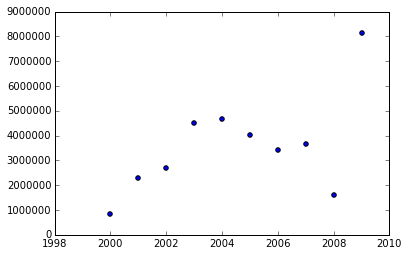

In [162]:
plt.scatter(range(startyear,endyear),long_term_port_by_ratio[0.5])

In [84]:
yearly_returns

[858265.49142536195,
 736618.43730107683,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]